In [1]:
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')
import numpy as np
import cv2
import matplotlib.pyplot as plt

In this part we define the following functions to implement Canny Edge Detection from scratch:

**Gaussian Blur:**

First we create a Gaussian kernel based on the specified kernel size and sigma standard deviation. Then we use convolution to apply it to the input image to smooth out noise and reduce detail.
    

**Gradient Calculation:**

Next, we use Sobel operators to detect intensity gradients in the x and y directions. The gradient magnitude ($G$) (strength of edges) and direction ($\theta$) (orientation of edges)are computed.
    

**Non-Maximum Suppression:**

Next, we implement Non-Max Suppression to sharpen edges by retaining only the local maxima along the gradient direction. We compare each pixel's gradient magnitude to its neighbors in the gradient direction and suppress non-maximum values.

    
**Hysteresis:**

We apply two thresholds (low and high) to classify pixels as strong (above the high threshold), weak (in between), or non-relevant (below the low threshold). Next, we connect weak edges to strong edges if they are adjacent, and discard weak edges that are not connected to strong ones.

In [2]:
def gaussian_blur(image, kernel_size=5, sigma=1.4):
    # Create a Gaussian kernel
    k = kernel_size // 2
    x, y = np.mgrid[-k:k+1, -k:k+1]
    gaussian_kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    gaussian_kernel /= gaussian_kernel.sum()
    
    # Apply Gaussian filter
    blurred_image = cv2.filter2D(image, -1, gaussian_kernel)
    return blurred_image

def sobel_filters(image):
    # Sobel kernels for x and y directions
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    Ix = cv2.filter2D(image, -1, Kx)
    Iy = cv2.filter2D(image, -1, Ky)
    
    # Gradient magnitude and direction
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return G, theta

def non_max_suppression(G, theta):
    M, N = G.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = theta * 180.0 / np.pi
    angle[angle < 0] += 180
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255
                
                # Angle 0
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = G[i, j+1]
                    r = G[i, j-1]
                # Angle 45
                elif 22.5 <= angle[i, j] < 67.5:
                    q = G[i+1, j-1]
                    r = G[i-1, j+1]
                # Angle 90
                elif 67.5 <= angle[i, j] < 112.5:
                    q = G[i+1, j]
                    r = G[i-1, j]
                # Angle 135
                elif 112.5 <= angle[i, j] < 157.5:
                    q = G[i-1, j-1]
                    r = G[i+1, j+1]

                if (G[i, j] >= q) and (G[i, j] >= r):
                    Z[i, j] = G[i, j]
                else:
                    Z[i, j] = 0
            except IndexError as e:
                pass
    
    return Z

def threshold(img, low, high):
    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)
    
    strong = 255
    weak = 75
    
    strong_i, strong_j = np.where(img >= high)
    zeros_i, zeros_j = np.where(img < low)
    
    weak_i, weak_j = np.where((img >= low) & (img < high))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return res

def hysteresis(img, weak=75, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == weak):
                # Check surrounding pixels
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

def canny_edge_detection(image, low_threshold, high_threshold):
    # Step 1: Gaussian blur
    blurred_image = gaussian_blur(image)
    
    # Step 2: Gradient calculation
    gradient_magnitude, gradient_direction = sobel_filters(blurred_image)
    
    # Step 3: Non-maximum suppression
    non_max_img = non_max_suppression(gradient_magnitude, gradient_direction)
    
    # Step 4: Double threshold
    thresh_img = threshold(non_max_img, low_threshold, high_threshold)
    
    # Step 5: Hysteresis
    edge_img = hysteresis(thresh_img)
    
    return edge_img

***Edges of runway:***

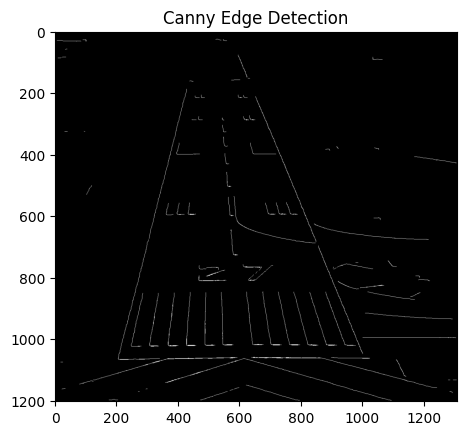

In [4]:
# Load and convert the image to grayscale
image = cv2.imread('/scratch/ne2213/computer-vision/runway.jpeg', cv2.IMREAD_GRAYSCALE)

# Run Canny edge detection and visualize
edges = canny_edge_detection(image, 50, 150)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.show()

 We can see that the important edges are highlighted with a good accuracy.

Next, we implement the Line Hough Transform from scratch, following these steps:

**Set Up Angle and Distance Ranges:**

First, we define an array of $\theta$ values from $0$ to $\pi$ with the specified resolution, and pre-compute the cosine and sine of each $\theta$ to speed up calculations. We also define a range of $\rho$ values, from the negative to positive maximum distance.

    
**Vote in the Accumulator:**

Next, we find the coordinates of edge pixels in the edge-detected image we got from applying Canny Edge Detection algorithm. Then, for each $\theta$, we calculate the corresponding $\rho$ values for each edge pixel based on its coordinates. We map these $\rho$ values to the nearest indices in the accumulator and increment the counts, to vote for the line candidates.


**Extract Lines:**

Finally, we identify peaks in the accumulator array where the votes exceed a specified threshold, and extract and store each significant $(\rho, \theta)$ pair as a detected line (compute the line's Cartesian coordinates)

In [5]:
def hough_line_transform(edges, rho_res=1, theta_res=np.pi/180, threshold=100):

    height, width = edges.shape
    max_dist = int(np.sqrt(height**2 + width**2))
    accumulator = np.zeros((2 * max_dist, int(np.pi / theta_res)), dtype=np.int32)
    
    # theta array and cosine and sine values
    thetas = np.arange(0, np.pi, theta_res)
    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)
    rhos = np.arange(-max_dist, max_dist, rho_res)
    
    # indices of edge pixels
    y_idxs, x_idxs = np.nonzero(edges)
    
    # rho values for each (x, y) and each theta
    for theta_idx, (cos_theta, sin_theta) in enumerate(zip(cos_thetas, sin_thetas)):
        rhos_values = x_idxs * cos_theta + y_idxs * sin_theta
        rhos_indices = np.round(rhos_values / rho_res + max_dist).astype(int)
        
        # Increment the accumulator
        np.add.at(accumulator, (rhos_indices, theta_idx), 1)

    # lines with votes above the threshold
    lines = []
    for rho_index, theta_index in np.argwhere(accumulator > threshold):
        rho = rhos[rho_index]
        theta = thetas[theta_index]
        lines.append((rho, theta))
    
    return lines

def draw_lines(image, lines):
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2) 

    return image

We draw the lines on the image calculated from the $(\rho, \theta)$ values. 

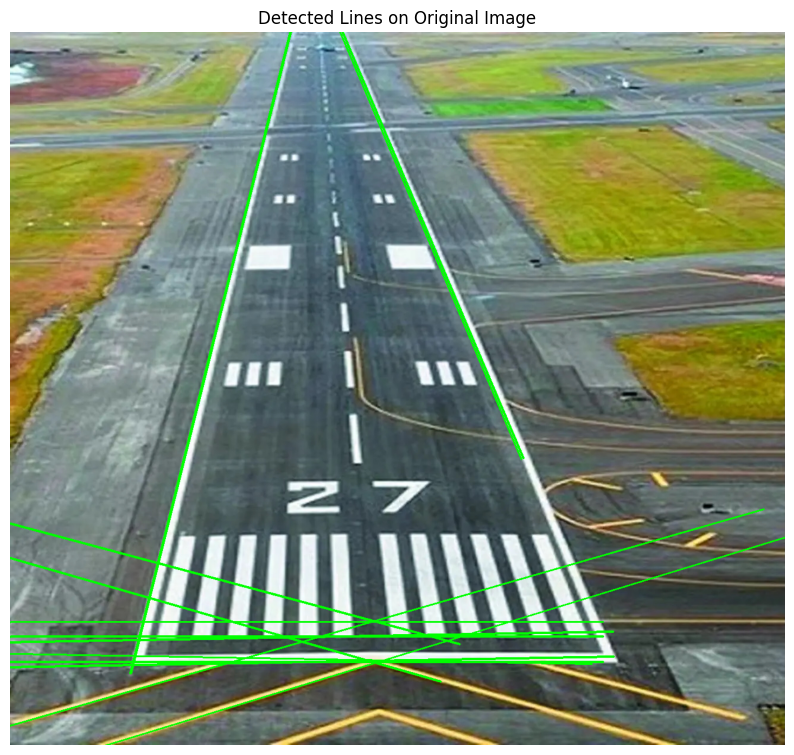

In [8]:
# Apply Hough Transform
detected_lines = hough_line_transform(edges, threshold=150)

# Draw lines on the original image
original_image = cv2.imread('/scratch/ne2213/computer-vision/runway.jpeg')
line_image = original_image.copy()
line_image = draw_lines(line_image, detected_lines)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines on Original Image')
plt.axis('off')
plt.show()

***Edges of landing pad:***

we first apply the Canny Edge Detection algorithm to identify the bounding edges of both the smaller circle and the larger circle in the landing pad:

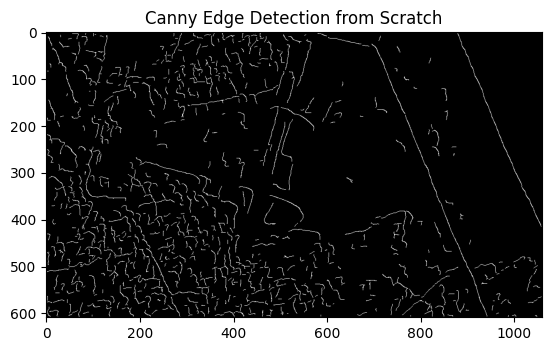

In [9]:
# convert to grayscale
image = cv2.imread('/scratch/ne2213/computer-vision/SpaceXmap.jpg', cv2.IMREAD_GRAYSCALE)

# contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(image)

# Gaussian blur
blurred_image = gaussian_blur(enhanced_image, kernel_size=7, sigma=5.0)

# Canny for circular edges
edges = canny_edge_detection(blurred_image, low_threshold=20, high_threshold=100)

plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection from Scratch')
plt.show()

As we can see, the important edges are not very well detected, so we lower the high and low thresholds and also apply a stronger Gaussian blur to better capture circular edges:

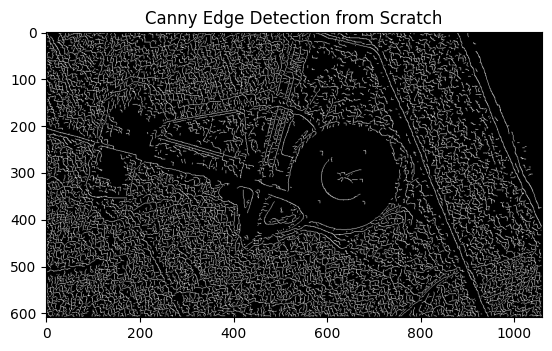

In [10]:
# convert to grayscale
image = cv2.imread('/scratch/ne2213/computer-vision/SpaceXmap.jpg', cv2.IMREAD_GRAYSCALE)

# Canny edge detection with stronger blur and lower thresholds
blurred_image = gaussian_blur(image, kernel_size=5, sigma=0.5)
edges = canny_edge_detection(blurred_image, 10, 20)

plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection from Scratch')
plt.show()

As we can see, more weak edges are identified which makes the image more noisy, but the circular edges are also better identified.

Next, we implement the Circle Hough Transform from scratch. The steps are as follows:

**Initialize the Accumulator Array:**

We initialize the  accumulator array, which is a 3D array of dimensions $(rows, cols, max\_radius)$, that represents possible circle centers and radius. We also create an array of $\theta$ values from 0 to 360 degrees (with a step size of 5 degrees to optimize performance), with precomputed $cos\_thetas$ and $sin\_thetas$ for efficient calculations.
    


**Voting Process:**

For each radius $r$ in the range, we compute the x and y offsets around a circle of radius $r$. Next, for each edge pixel $(x, y)$, we calculate circle perimeter points using these values, and vote in the accumulator to get the potential circle centers.
    


**Circle Extraction with Non-Maximum Suppression:**

Finally, the detected circles are points in the accumulator with votes above a threshold we set. We also apply Non-maximum suppression for each circle candidate $(a, b, r)$. We draw each detected circle on the output image.

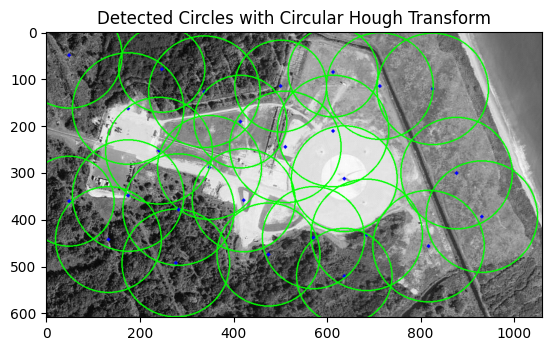

In [12]:
# Parameters
min_dist = 100
param_ = 40
min_radius = 90
max_radius = 120
theta_step = 5 

# Image dimensions
rows, cols = edges.shape
accumulator = np.zeros((rows, cols, max_radius), dtype=np.uint8)

# cosine and sine for theta angles
thetas = np.deg2rad(np.arange(0, 360, theta_step))
cos_thetas = np.cos(thetas)
sin_thetas = np.sin(thetas)

# Voting process on edge pixels
for r in range(min_radius, max_radius):
    r_cos_thetas = r * cos_thetas
    r_sin_thetas = r * sin_thetas
    
    for x, y in np.argwhere(edges): 
        # circle edge coordinates for current radius
        a_points = np.clip((x - r_cos_thetas).astype(int), 0, rows - 1)
        b_points = np.clip((y - r_sin_thetas).astype(int), 0, cols - 1)
        
        # Accumulate votes
        accumulator[a_points, b_points, r] += 1

# circles above threshold (non-max suppression)
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
detected_circles = []

for a, b, r in zip(*np.where(accumulator >= param_)):
    # nearby circle within min_dist
    if not any(np.sqrt((a - cx)**2 + (b - cy)**2) < min_dist for cx, cy, cr in detected_circles):
        detected_circles.append((a, b, r))

# Draw 
for a, b, r in detected_circles:
    cv2.circle(output_image, (b, a), r, (0, 255, 0), 2)  
    cv2.circle(output_image, (b, a), 2, (0, 0, 255), 3)  

plt.imshow(output_image)
plt.title('Detected Circles with Circular Hough Transform')
plt.axis('off')
plt.show()


We can see that the result is not ideal, as many circles have been detected. However, we can see one of these circles matches the landing pad perfectly.